# Data Analysis

This notebook analyses the results of the element categorization and area estimations from the last notebook.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [3]:
import os
import sys
import json
import time
import glob
import tempfile
import warnings
import inspect
from collections import Counter
from multiprocessing import Pool
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.stats import t
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from bs4 import BeautifulSoup
from tqdm import tqdm
from IPython.display import display

sys.path.append("..")
from utils.config import (
    google_domains,
    cat2color
)

In [4]:
# variables
subsample = True
data_dir = '../data' if not subsample else '../data_subsample'

In [5]:
# input
fn_metadata = f'{data_dir}/intermediary/element_metadata.jsonl.gz'

# output
output_dir = f'{data_dir}/output'
tables_dir = os.path.join(output_dir, 'tables/')
figure_dir = os.path.join(output_dir, 'figures/')
appendix_dir = os.path.join(output_dir, 'appendix/')

for d in [tables_dir, figure_dir, appendix_dir]:
    os.makedirs(d, exist_ok=True)

In [6]:
df = pd.read_json(fn_metadata, 
                  lines=True, 
                  compression='gzip')

In [7]:
df.memory_usage(index=True, deep=True).sum() / 1e-9

7.4902109e+16

In [8]:
# recall a record looks like this
df.sample(1).iloc[-1].to_dict()

{'text': 'frocktober poster',
 'link': '/search?q=frocktober+poster&sa=X&ved=2ahUKEwiE4tPl-tPlAhUEUt8KHT2tDr8Q1QIwDnoECAsQAg',
 'domain': 'google.com',
 'xpath': '/html/body/div[10]/div/div[6]/div/div[4]/div/div/div[1]/div/div/a[1]',
 'category': 'link-google',
 'tag': 'a',
 'attrs': {'class': ['F3dFTe'],
  'href': '/search?q=frocktober+poster&sa=X&ved=2ahUKEwiE4tPl-tPlAhUEUt8KHT2tDr8Q1QIwDnoECAsQAg'},
 'dimensions': {'height': 48.0, 'width': 315.0},
 'location': {'x': 24, 'y': 2270},
 'area_page': 15120.0,
 'fn_input': '../data/input/google_search/iPhone-X/2019/11/05/Frocktober/html/webpage_raw.html',
 'position_last_element': 2425,
 'fn_metadata': '../data_subsample/intermediary/google_search/iPhone-X/2019/11/05/Frocktober/json/parsed_meta.jsonl',
 'q1_area': 0.0,
 'q2_area': 0.0,
 'q3_area': 0.0,
 'q4_area': 0.0,
 'q5_area': 0.0,
 'q6_area': 0.0,
 'q7_area': 0.0,
 'q8_area': 0.0,
 'q9_area': 0.0,
 'q10_area': 0.0,
 'q11_area': 0.0,
 'q12_area': 0.0,
 'q13_area': 0.0,
 'q14_area': 0.

In [9]:
total_area = df.area_above_the_fold.sum()
total_area_fp = df.area_page.sum()

In [10]:
label2publabel = {
    'link' : 'Google Product',
    'answer' : 'Google Answer',
    'organic' : 'Non-Google',
    'amp' : 'AMP',
    'ads' : 'Ads'
}

\begin{equation}
X_{g} = \frac{g}{g + o + amp + ad}
\end{equation}



Where <br>
&nbsp;&nbsp;&nbsp;&nbsp; $X_{g}$: is the percentage of real estate that occupied by Google.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $g$: is the sum of real estate pixels occupied by Google products and answers.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $o$: is the sum of real estate pixels occupied by Non-Google.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $amp$: is the sum of real estate pixels occupied by AMP.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $ad$: is the sum of real estate pixels occupied by ads.<br>

## Breakdown of area and frequency for each category
For a more granular look at how much space is occupied by each search feature:

In [11]:
# get area per standardized category
cat_area_ = (df.groupby('category_standard')
               .area_page.sum()
               .divide(total_area)
               .sort_values(ascending=False))

cat_area =(df.groupby('category_standard')
             .area_above_the_fold.sum()
             .divide(total_area_fp)
             .sort_values(ascending=False))

In [12]:
cat_area

category_standard
google-answer                   0.029801
google-images                   0.017900
organic-search_result           0.016142
amp-card                        0.014511
google-misc                     0.012673
organic                         0.010479
google-knowledge-panel-links    0.009731
ads                             0.008339
google-search                   0.004549
google-expandable-answer        0.003522
google-maps                     0.002558
google-video                    0.001678
amp-visual_stories              0.000457
amp-search_result               0.000370
Name: area_above_the_fold, dtype: float64

In [13]:
# how many records are in our dataset, again?
n_pages = df[df.area_page != 0].fn_input.nunique()
n_pages

400

In [14]:
# number of elements on the top of the page
cat_count = Counter()
for fn, _df in df[df.area_above_the_fold != 0].groupby('fn_input'):
    cat_count.update(_df.category_standard.unique())
df_wc = pd.DataFrame(cat_count.most_common(50),
                     columns=['category_standard', 'count'])
df_wc['freq'] = df_wc['count'] / n_pages 

# number of elements on full page
cat_count_ = Counter()
for fn, _df in df[df.area_page != 0].groupby('fn_input'):
    cat_count_.update(_df.category_standard.unique())
df_wc_ = pd.DataFrame(cat_count_.most_common(50),
                     columns=['category_standard', 'count_page'])
df_wc_['freq_page'] = df_wc_['count_page'] / n_pages 

In [15]:
# get all the names of things for each label (category).
cat_amp = df[df.label == 'amp'].category_standard.unique()
cat_sd = df[df.label == 'link'].category_standard.unique()
cat_rt = df[df.label == 'answer'].category_standard.unique()
cat_ad = df[df.label == 'ads'].category_standard.unique()
cat_og = df[df.label == 'organic'].category_standard.unique()

In [16]:
def format_number(x):
    """Makes it nice for printing"""
    x = x * 100
    x = round(x, 2)
    return f"{x}%"

In [17]:
def breakdown(categories : list(), 
              col='category_standard',
              area_col='area_above_the_fold'):
    """Shows the area coverage and page frequency for each category  """
    full_page =df_wc_[df_wc_[col].isin(categories)] \
            .join(cat_area_.to_frame(),
                  on=col,
                  how='left')

    output = (df_wc[df_wc[col].isin(categories)]
        .join(cat_area.to_frame(),
              on=col,
              how='left')
        .sort_values(by=[area_col], 
                     ascending=False)
        .reset_index(drop=True)
        .merge(full_page)
    )
    
    output = output[[c for c in output.columns if 'count' not in c]]
        
    fg_area = output[area_col].sum()
    fp_area = output['area_page'].sum()
    
    output = output.append(
        {'category_standard' : 'Total', 
         'freq' : np.nan, 
         area_col : fg_area, 
         'freq_page' : np.nan, 
         'area_page' : fp_area},
        ignore_index=True
    )
    return output.set_index(col)


## Breakdown of area and frequency for each category

In [21]:
columns = [
   ('Top of page', 'area'),
   ('Top of page' , 'area'),
   ('Full page', 'freq'),
   ('Full page' , 'area'),
]

In [22]:
total_area = df.area_above_the_fold.sum()
total_area_fp = df.area_page.sum()
n_pages = df.fn_input.nunique()

In [23]:
labels_in_order = [
    'organic',
    'amp',
    'answer',
    'link',
    'ads'
]

In [24]:
df_cat_agg = pd.DataFrame()
for categories in [cat_ad, cat_amp, cat_rt, cat_sd, cat_og]:
    output = breakdown(categories)
    df_cat_agg = df_cat_agg.append(output)
    
    output.columns = pd.MultiIndex.from_tuples([
       ('Top of page', 'freq'),
       ('Top of page' , 'area'),
       ('Full page', 'freq'),
       ('Full page' , 'area'),
    ])
    for c, dtype in output.dtypes.items():
        if pd.api.types.is_numeric_dtype(output[c]):
            output[c] = output[c].apply(format_number)
    
    display(output)

Top of page        Full page       
                         freq   area      freq   area
category_standard                                    
ads                      8.0%  0.83%     9.25%  7.28%
Total                    nan%  0.83%      nan%  7.28%

Top of page        Full page        
                          freq   area      freq    area
category_standard                                      
amp-card                17.75%  1.45%     53.0%  31.88%
amp-visual_stories       2.75%  0.05%     5.25%   0.66%
amp-search_result        0.75%  0.04%    62.25%  62.11%
Total                     nan%  1.53%      nan%  94.64%

Top of page        Full page         
                                freq   area      freq     area
category_standard                                             
google-answer                  60.5%  2.98%    94.25%   47.63%
google-expandable-answer      17.25%  0.35%    87.75%   53.63%
Total                           nan%  3.33%      nan%  101.26%

Top of page        Full page         
                                    freq   area      freq     area
category_standard                                                 
google-images                      64.0%  1.79%     84.0%   19.31%
google-misc                        85.5%  1.27%     99.0%   28.46%
google-knowledge-panel-links      70.75%  0.97%    77.75%    8.77%
google-search                      25.5%  0.45%    100.0%  118.56%
google-maps                        7.25%  0.26%     10.0%    3.13%
google-video                       9.75%  0.17%     55.0%   26.41%
Total                               nan%  4.91%      nan%  204.64%

Top of page        Full page         
                             freq   area      freq     area
category_standard                                          
organic-search_result       25.5%  1.61%    100.0%  298.74%
organic                     67.5%  1.05%     96.5%   46.96%
Total                        nan%  2.66%      nan%   345.7%

## Ratios

## Table 1

In [18]:
fn_cats = f'{data_dir}/output/tables/T1_area_freq_by_category.csv'

In [19]:
data = {}
for label in df.label.unique():
    _df = df[df.label == label]
    area = (_df['area_above_the_fold'].sum() / total_area)
    freq = _df[_df['area_above_the_fold'] != 0].fn_input.nunique() / n_pages
    
    area_page = (_df['area_page'].sum() / total_area_fp)
    freq_page = _df[_df['area_page'] != 0].fn_input.nunique() / n_pages
    
    data[label2publabel.get(label,label)] = {
        ('Top of page', 'area') : area,
        ('Top of page', 'freq') : freq,
        ('First page', 'area') : area_page,
        ('First page', 'freq') : freq_page,
    }
    
cat_breakdown = pd.DataFrame(data).T
cat_breakdown.columns = pd.MultiIndex.from_tuples([
    ('Top of page', 'area'),
    ('Top of page', 'freq'),
    ('First page', 'area'),
    ('First page', 'freq'),
])

print((cat_breakdown * 100).round(1).astype(str) + '%')

               Top of page        First page        
                      area   freq       area    freq
Ads                   6.3%   8.0%       1.0%    9.2%
Google Product       37.0%  93.8%      27.2%  100.0%
Google Answer        25.1%  70.8%      13.4%   98.8%
AMP                  11.6%  21.2%      12.6%   74.5%
Non-Google           20.1%  80.0%      45.9%  100.0%


In [20]:
cat_breakdown.to_csv(fn_cats)

In [21]:
fn_pixels = f'{data_dir}/intermediary/pixels_above_the_fold.csv'
fn_pixels_page = f'{data_dir}/intermediary/pixels_page.csv'

In [22]:
labels_in_order = [
    'organic',
    'amp',
    'answer',
    'link',
    'ads'
]

In [28]:
area_cols = ['area_above_the_fold', 'area_page']

In [52]:
pixels = {c : list() for c in area_cols}
for search, df_ in tqdm(df.groupby('fn_input'), position=0, leave=True):
    for col in area_cols:
        # get sum of pixels for each label.
        ad = df_[df_.label == 'ads'][col].sum()
        o = df_[df_.label == 'organic'][col].sum()
        g = df_[(df_.label == 'link') | (df_.label == 'answer')][col].sum()
        a =  df_[df_.label == 'answer'][col].sum()
        amp = df_[df_.label == 'amp'][col].sum()
        
        # equations
        e1 =  o / (g + ad + o + amp)
        e2 = g / (g + ad + o + amp)

        row = {
            'search_term' : search,
            'ad' : ad,
            'o' : o,
            'g' : g,
            'a' : a,
            'amp' : amp,
            'e1' : e1,
            'e2' : e2,
        }

        pixels[col].append(row)
    
df_pixels = pd.DataFrame(pixels['area_above_the_fold'])
df_pixels_fp = pd.DataFrame(pixels['area_page'])

df_pixels.e1.fillna(0, inplace=True)
df_pixels.e2.fillna(0, inplace=True)

100%|██████████| 400/400 [00:02<00:00, 182.52it/s]


In [30]:
df_pixels.to_csv(fn_pixels, index=False)
df_pixels_fp.to_csv(fn_pixels_page, index=False)

## Histogram of Google-occupied pixels

In [53]:
def hist(series, color='black', 
         title=None, 
         fn_out=None,
         left_right_annotations = (None, None)):
    ax = series.plot(kind='hist', 
                           figsize=(10,6),
                           bins=10, 
                           rwidth=.95,
                           color=color,
                           alpha=.9,
                           title=title)

    ax.tick_params(axis="both", which="both", bottom="off", 
                   top="off", labelbottom="on", left="off", 
                   right="off", labelleft="on")

    plt.annotate(left_right_annotations[0], 
                 (0.04, 0), (0, -21), 
                 xycoords='axes fraction', 
                 textcoords='offset points', 
                 va='top')
    plt.annotate(left_right_annotations[-1], 
                 (.75, 0), (.75, -21), 
                 xycoords='axes fraction', 
                 textcoords='offset points', 
                 va='top')

    ax.set_ylabel("Count of search pages")

    ax.set_axisbelow(True)
    plt.gca().yaxis.grid(True)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    if fn_out:
         plt.savefig(fn_out)
    
    return ax

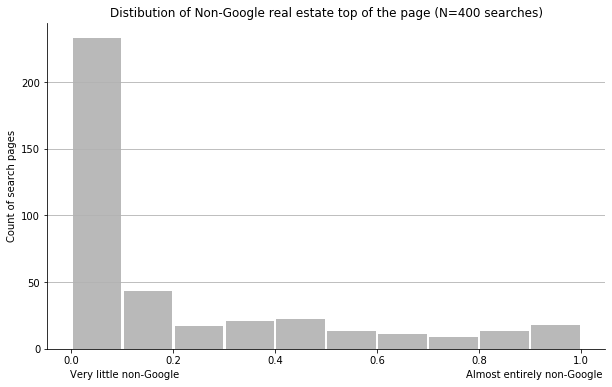

In [54]:
hist(df_pixels.e1,
     left_right_annotations = ('Very little non-Google',
                               'Almost entirely non-Google'),
     color=cat2color['organic'],
     title = f'Distibution of Non-Google real estate top of the page (N={len(df_pixels):,} searches)',
     fn_out='../data/output/figures/eq1_abv.png');

In [55]:
# What percentage of pages have 10% or less of the page occupied by Non-Google?
len(df_pixels[df_pixels.e1 <= .1]) / len(df_pixels) * 100

58.25

In [56]:
df_pixels.e1.mean(), df_pixels.e1.median()

(0.20060110647001203, 0.044912356827879994)

In [57]:
# what is the standard error?
(df_pixels.e1.sem()) * 100

1.4312050779916208

What about the full page?

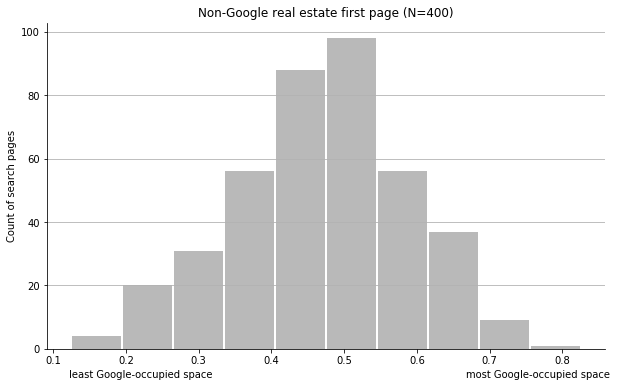

In [58]:
hist(df_pixels_fp.e1,
     title=f'Non-Google real estate first page (N={len(df_pixels):,})',
     left_right_annotations = ('least Google-occupied space',
                               'most Google-occupied space'),
     color=cat2color['organic'],
     fn_out='../data/output/figures/eq1_page.png');

In [59]:
# What percentage of pages have 50% or more of the page occupied by non-Google?
len(df_pixels_fp[df_pixels_fp.e1 >= .5]) / len(df_pixels) * 100

41.5

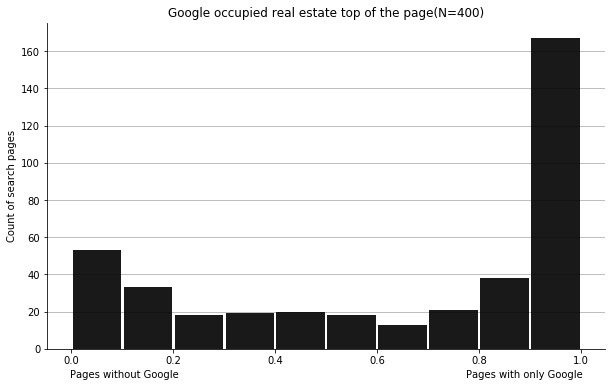

In [60]:
hist(df_pixels.e2,
     color='k',
     title = f'Google occupied real estate top of the page(N={len(df_pixels):,})',
     left_right_annotations=('Pages without Google',
                             'Pages with only Google'),
     fn_out='../data/output/figures/eq2_above.png')

In [61]:
# What percentage of pages have 90% or more of the page occupied by Google?
len(df_pixels[df_pixels.e2 >= .9]) / len(df_pixels) * 100

41.75

In [62]:
len(df_pixels[df_pixels.e1 < .25]) / len(df_pixels) * 100

72.25

## Figure 2
Like the histogram above, lets bin the data to show the distribution of area coverage per category in our sample:

In [86]:
fn_fig2 = os.path.join(figure_dir, '2-normalized-bar.png')

In [63]:
non_google_bins = (pd.cut(df_pixels.e1, bins=4).value_counts() / 
                   n_pages).sort_index()
non_google_bins

(-0.001, 0.25]    0.7225
(0.25, 0.5]       0.1175
(0.5, 0.75]       0.0750
(0.75, 1.0]       0.0850
Name: e1, dtype: float64

In [64]:
google_bins = (pd.cut(df_pixels.e2, bins=4).value_counts() / 
               n_pages).sort_index()
google_bins

(-0.001, 0.25]    0.2375
(0.25, 0.5]       0.1200
(0.5, 0.75]       0.0950
(0.75, 1.0]       0.5475
Name: e2, dtype: float64

In [65]:
cmap = plt.cm.get_cmap('gray_r')
colors = iter(cmap(np.linspace(0.2,.7,4)))
labels = [
    'Very little coverage',
    'Some coverage',
    'More coverage',
    'Almost entirely covered'
]
legend_elements = [Line2D([0], [0], marker='s', color='w', 
                          label=labels[i],
                          markerfacecolor=c, markersize=10)
                   for i, c in enumerate(colors)][::-1]

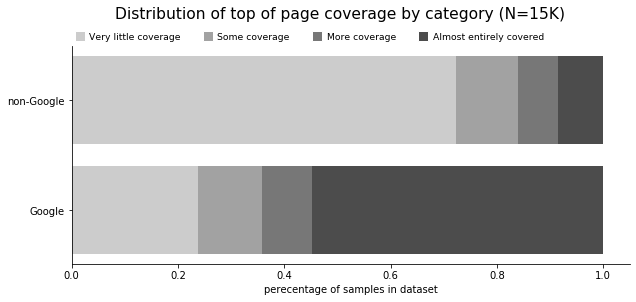

In [87]:
cmap = plt.cm.get_cmap('gray_r')
colors = iter(cmap(np.linspace(0.2,.7,4)))

colors_g = iter(cmap(np.linspace(0.2,.7,4)))

# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,4))

# Set bar width at 1
bar_width = 1
_google = google_bins.values
_non_google = non_google_bins.values
for i, data in enumerate(_google):
    if i != 0:
        ax.barh('Google', data, 
                left=sum(_google[:i]),
                 linewidth=0,
                 color=next(colors_g)
               );
    else:
        ax.barh('Google', data,
               color=next(colors_g)
               );
        
for i, data in enumerate(_non_google):
    if i != 0:
        ax.barh('non-Google', data, color=next(colors), left=sum(_non_google[:i]));
    else:
        ax.barh('non-Google', data, color=next(colors))

plt.title("Distribution of top of page coverage by category (N=15K)",
           x=0.48,
         y=1.1,
         size=15.5)
        
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('perecentage of samples in dataset')
ax.legend(handles=legend_elements[::-1],
          loc='lower left', 
          bbox_to_anchor= (-0.005, 1.015), ncol=5,
          handletextpad=0.0,
          labelspacing=0, 
          borderaxespad=.1, 
          borderpad=0.1,
          frameon=False,
          prop={'size': 9.2})

plt.savefig(fn_fig2)
plt.show();

# Distance

In [88]:
fn_fig3 = os.path.join(figure_dir, '3-distance_normalized.png')

In [72]:
df.loc[:, 'y_dist'] = df.location.apply(lambda x: x['y'])

In [73]:
df.loc[df['category'] == 'link-youtube', 
       "category_standard"] = 'youtube'
df.loc[df['category'] == 'link-youtube_search_result', 
       "category_standard"] = 'youtube-search-result'

In [74]:
blue_link_categories = [
    'organic-search_result',
    'amp-search_result',
    "youtube-search-result"
]

In [75]:
standard_categories = [
    "organic-search_result",
    "organic",
    "ads",
    "amp-card",
    "amp-visual_stories",
    "google-images",
    "youtube",
    "google-maps",
    'google-answer',
    "google-search",
    "amp-search_result",
    "youtube-search-result",
]

In [76]:
cat2name = {
    "ads" : 'Ad',
    "organic" : 'non-\nGoogle\nLink',
    "amp-card" : 'AMP\nArticle',
    "amp-visual_stories" : "AMP\nVisual\nStory",
    "google-images" : 'Google\nImages',
    "youtube": 'YouTube',
    "google-maps" : 'Google\nMaps',
    'google-answer' : 'Direct\nAnswer',
    'google-search' : 'Google\nSearch',
    "organic-search_result" : 'non-\nGoogle\nBlue\nLink'
}

In [77]:
df.category_standard.value_counts()

google-search                   7496
google-answer                   3450
google-misc                     2968
organic                         2903
organic-search_result           2890
google-images                   2580
google-expandable-answer        2505
youtube                         1892
google-knowledge-panel-links    1553
amp-card                        1264
amp-search_result                935
ads                              149
google-maps                       55
google-video                      32
youtube-search-result             30
amp-visual_stories                22
Name: category_standard, dtype: int64

Here we get distance down the page we'd have to for before seeing specific search features (`standard_categories`).

Note, we normalize the length down a page between 0 (below the search bar and headers) and 1 (below the "More results" button).

In [78]:
header = 160
normalize = True

In [79]:
dist = {k : [] for k in standard_categories}
for site, _df in tqdm(df[df.area_page != 0].groupby('fn_input')):
    end_of_page = _df['position_last_element'].iloc[0] - header
    for cat in standard_categories:
        # a tweak for blue links.
        _df.category_standard = _df.category_standard.replace({'amp-search_result' :'organic-search_result',
                                                               'youtube-search-result' : 'organic-search_result'})
        __df = _df[_df.category_standard == cat]
        if not __df.empty:
            # normalized page
            if normalize:
                y_min = (__df.y_dist.min() - header) / end_of_page
            else:
                y_min =__df.y_dist.min()
            dist[cat].append(y_min)

100%|██████████| 400/400 [00:03<00:00, 107.46it/s]


In [80]:
for k in ['amp-search_result', 'youtube-search-result']:
    dist.pop(k)

In [81]:
data = []
for cat, v in dist.items():
    dato = pd.DataFrame({'dist_y' : v}).dist_y
    mean = dato.mean()
    median = dato.median()
    err = dato.sem()
    std = dato.std()
    data.append({
        'category' : cat,
        'dist' : mean,
        'dist_median' : median,
        'min' : dato.describe()['min'],
        '25' : dato.describe()['25%'],
        '50' : dato.describe()['50%'],
        '75' : dato.describe()['75%'],
        'max' : dato.describe()['max'],
        'std' : std,
        'sem_error' : err,
        'n' : len(v)
    })
df_dist = pd.DataFrame(data)
del data

organic-search_result


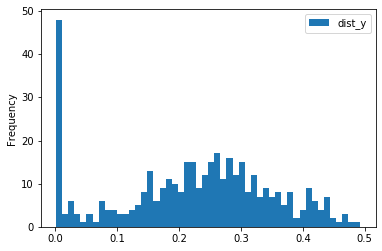

organic


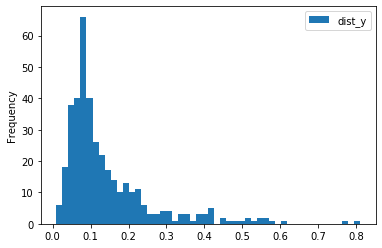

ads


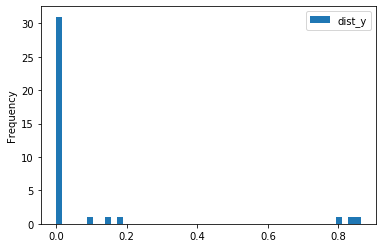

amp-card


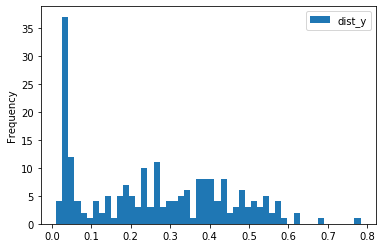

amp-visual_stories


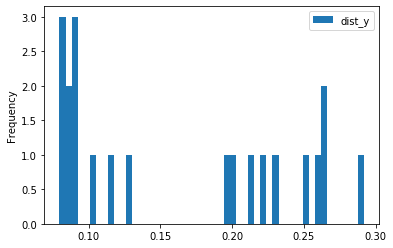

google-images


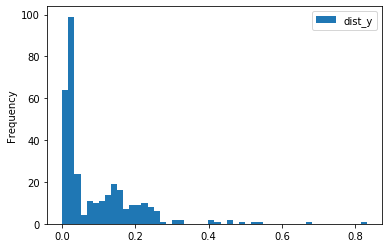

youtube


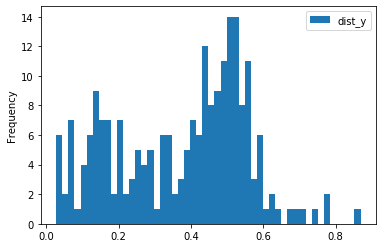

google-maps


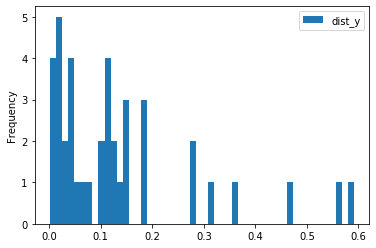

google-answer


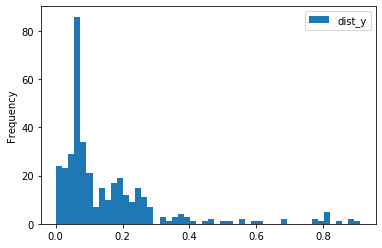

google-search


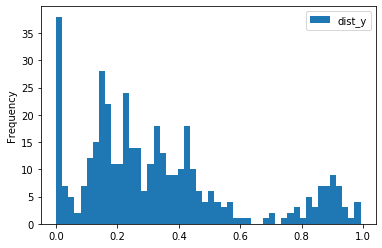

In [82]:
data = []
for cat, v in dist.items():
    print(cat)
    dato = pd.DataFrame({'dist_y' : v})
    dato.plot(kind='hist', bins=50)
    plt.show();

In [85]:
df_dist

,category,dist,dist_median,min,25,50,75,max,std,sem_error,n
0,organic-search_result,0.222717,0.237787,0.001052,0.146613,0.237787,0.309680,0.493003,0.127622,0.006381,400
1,organic,0.143706,0.097133,0.009008,0.070220,0.097133,0.171759,0.811024,0.121782,0.006199,386
2,ads,0.081285,0.001507,0.000864,0.001225,0.001507,0.005768,0.862385,0.229322,0.037700,37
3,amp-card,0.261532,0.258827,0.010838,0.058867,0.258827,0.405083,0.782848,0.181977,0.012498,212
4,amp-visual_stories,0.163761,0.129515,0.079671,0.089205,0.129515,0.231886,0.291788,0.078428,0.017114,21
5,google-images,0.093915,0.035353,0.001183,0.023633,0.035353,0.147644,0.831275,0.110765,0.006043,336
6,youtube,0.373460,0.426035,0.026871,0.209724,0.426035,0.511561,0.868764,0.181682,0.012249,220
7,google-maps,0.135072,0.106660,0.001183,0.035088,0.106660,0.158913,0.591658,0.147399,0.023306,40
8,google-answer,0.154712,0.085452,0.001010,0.061918,0.085452,0.199428,0.912221,0.168108,0.008658,377
9,google-search,0.331172,0.265855,0.000622,0.148211,0.265855,0.431175,0.992005,0.261697,0.013085,400


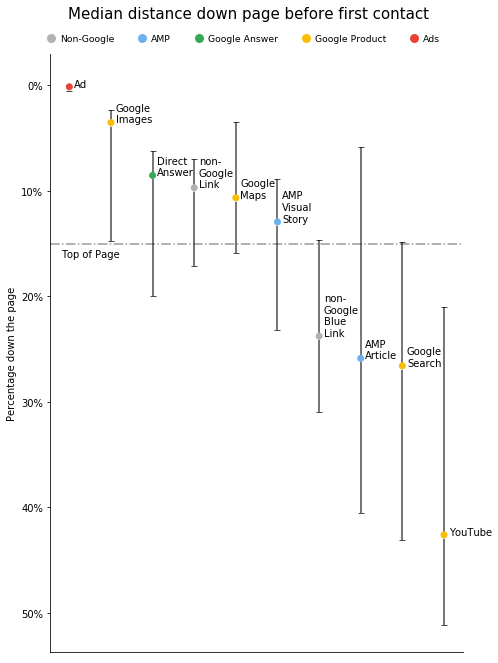

In [89]:
legend_elements = [Line2D([0], [0], marker='o', color='w', 
                          label=label2publabel.get(label),
                          markerfacecolor=c, markersize=10)
                   for label, c in cat2color.items()][::-1]

fig, ax = plt.subplots(figsize=(7.4, 11))
col = '50'
data = df_dist.sort_values(by=col)
labels = [cat.replace('google-answer', 'answer')
                            .replace('google-expandable-answer', 'answer')
                            .split('-')[0]
                            .replace('google', 'link')
                            .replace('youtube', 'link') for cat in data.category]

colors = [cat2color.get(label) for label in labels]


plt.scatter(data.category, data[col], 
            c=colors, zorder=100)

plt.errorbar(data.category, col, 
             data=data,
             yerr=[data[col] - data['25'], 
                   data['75']- data[col]], 
             ecolor='k', color='white',
             capsize = 3,  fmt='o',
             alpha=.7)

plt.gca().invert_yaxis()
plt.axhline(y=.15, color='black', linestyle='-.', alpha=.4)
# plt.annotate('Top of Page', (8, .143))
plt.annotate('Top of Page', (-.2, .163))


plt.xticks(rotation=90)
for i, (_, row) in enumerate(data.iterrows()):
    txt = row['category']
    x = i + .11
    y = row[col]
    plt.annotate(cat2name.get(txt, txt), 
                 (x, y), 
                 ha='left',
                 zorder=200)


ax.set_ylabel("Percentage down the page")

ax.legend(handles=legend_elements[::-1],
          loc='lower left', 
          bbox_to_anchor= (-0.025, 1.015), ncol=5,
          handletextpad=0.0,
          labelspacing=0, 
          borderaxespad=.1, 
          borderpad=0.1,
          frameon=False,
          prop={'size': 9.2}
         )

plt.title('Median distance down page before first contact',
         x=0.48,
         y=1.05,
         size=15.)

# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

ax.set_axisbelow(True)
# plt.gca().yaxis.grid(True)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_visible(False)

plt.savefig(fn_fig3)
del data;
plt.show();